# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import os
import shutil
import subprocess
import zipfile
import re
import random
from sklearn.preprocessing import MinMaxScaler

## Global Definitions

In [ ]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

window_size = 60

model_dim = 128
num_heads = 4
num_layers = 2

In [10]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [ ]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=64):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")  # Debugging shapes
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    print(f"Shape of X_tensor: {X_tensor.shape}, Shape of y_tensor: {y_tensor.shape}")  # Debugging shapes
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, teacher_forcing_prob=0.5):
    """
    Train the given model with validation and return training/validation metrics.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    huber_criterion = nn.HuberLoss(delta=1.0)  # Use HuberLoss
    mae_criterion = nn.L1Loss()

    train_huber_losses, val_huber_losses = [], []
    train_mae_losses, val_mae_losses = [], []

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_huber, total_train_mae, total_train_samples = 0.0, 0.0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            preds = model(batch_x)

            # Teacher forcing
            if random.random() < teacher_forcing_prob:
                batch_x = batch_x.clone()
                batch_x[:, -1, 0] = batch_y[:, 0]

            # Compute loss
            loss = huber_criterion(preds, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            # Track training metrics
            batch_size = batch_x.size(0)
            total_train_samples += batch_size
            total_train_huber += huber_criterion(preds, batch_y).item() * batch_size
            total_train_mae += mae_criterion(preds, batch_y).item() * batch_size

            pbar.set_postfix(huber_loss=loss.item())

        avg_train_huber = total_train_huber / total_train_samples
        avg_train_mae = total_train_mae / total_train_samples
        train_huber_losses.append(avg_train_huber)
        train_mae_losses.append(avg_train_mae)

        # Validation phase
        model.eval()
        total_val_huber, total_val_mae, total_val_samples = 0.0, 0.0, 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)

                batch_size = batch_x.size(0)
                total_val_samples += batch_size
                total_val_huber += huber_criterion(preds, batch_y).item() * batch_size
                total_val_mae += mae_criterion(preds, batch_y).item() * batch_size

        avg_val_huber = total_val_huber / total_val_samples
        avg_val_mae = total_val_mae / total_val_samples
        val_huber_losses.append(avg_val_huber)
        val_mae_losses.append(avg_val_mae)

        # Save the best model
        if avg_val_huber < best_val_loss:
            best_val_loss = avg_val_huber
            best_model_state = model.state_dict()

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Huber={avg_train_huber:.4f}, Val Huber={avg_val_huber:.4f}, Train MAE={avg_train_mae:.4f}, Val MAE={avg_val_mae:.4f}")

    # Load the best model
    model.load_state_dict(best_model_state)

    return train_huber_losses, val_huber_losses, train_mae_losses, val_mae_losses

def plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions_rescaled, actual_values, save_path="training_summary.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Define the number of epochs
    epochs = len(train_mse_losses)
    epoch_ticks = range(1, epochs + 1)  # Epoch numbers start from 1

    # Plot MSE Loss
    plt.subplot(1, 3, 1)
    plt.plot(epoch_ticks, train_mse_losses, label="Train MSE", color="blue")
    plt.plot(epoch_ticks, val_mse_losses, label="Val MSE", color="orange")
    plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Mean Squared Error (MSE) Loss")
    plt.legend()

    # Plot MAE Loss
    plt.subplot(1, 3, 2)
    plt.plot(epoch_ticks, train_mae_losses, label="Train MAE", color="green")
    plt.plot(epoch_ticks, val_mae_losses, label="Val MAE", color="red")
    plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Mean Absolute Error (MAE) Loss")
    plt.legend()

    # Plot Actual vs Predicted Values
    plt.subplot(1, 3, 3)
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   


def recursive_forecast(model, init_window, steps=200, std=1.0, mean=0.0):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            pred = model(current_seq.unsqueeze(0))  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred[0, 0].item()  # Extract the first step of the forecast

            # Debugging: Print the prediction for the current step
            if step < 10:  # Print only the first 10 predictions for brevity
                print(f"Step {step}: Prediction={pred_value}")

            # Append the prediction
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], torch.tensor([[pred_value]], device=device)), dim=0)

            # Optional: Clamp predictions to avoid divergence
            current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    # Rescale predictions back to the original range
    preds_rescaled = np.array(preds) * std + mean

    print(f"first 10 predictions: {preds_rescaled[:10]}")
    return preds_rescaled

### Transformer Model

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()
        self.encoding = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-np.log(10000.0) / model_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension


    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len, :].to(x.device)


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=128, num_heads=8, num_layers=4, max_len=5000, forecast_steps=5):

        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(model_dim, model_dim // 2)
        self.fc2 = nn.Linear(model_dim // 2, forecast_steps)

        self.initialize_weights()  # Initialize weights

    def forward(self, x):
        x = self.dropout(self.input_proj(x))
        x = self.positional_encoding(x)
        x = self.dropout(self.transformer(x))
        x = self.norm(x)
        x = F.relu(self.fc1(x[:, -1]))
        return self.fc2(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.TransformerEncoderLayer):
                nn.init.xavier_uniform_(m.self_attn.in_proj_weight)
                nn.init.xavier_uniform_(m.self_attn.out_proj.weight)

### Load and Split the dataset into train-validation

In [13]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print("First 5 rows of Xtrain:")
print(Xtrain[:5])

# Normalizing
mean, std = Xtrain.mean(), Xtrain.std()
Xtrain_normalize = (Xtrain - mean) / std

# Creating sequences
X_all, y_all = create_sequences(Xtrain_normalize, window_size)  # Use normalized data

# Remove redundant normalization of y_all
# y_all is already normalized because it is derived from Xtrain_normalize

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.25, random_state=42)

# Prepare DataLoaders for training and validation
train_loader, _, _ = prepare_dataloader(X_train, window_size)
val_loader, _, _ = prepare_dataloader(X_val, window_size)

# Debugging: Check the range of X_val and y_val
print(f"X_val range: min={X_val.min()}, max={X_val.max()}")
print(f"y_val range: min={y_val.min()}, max={y_val.max()}")


# Print dataset information
print(f"Total dataset size: {X_all.shape[0]} samples")
print(f"Input sequence shape: {X_all.shape[1:]} (sequence length: {window_size})")
print(f"Target shape: {y_all.shape}")

# Print split information
print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

# Print DataLoader information
print(f"Training DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

# Debugging: Check the range of X_val
print(f"X_val range: min={X_val.min()}, max={X_val.max()}")

# Debugging: Check the range of X_val
print(f"X_train range: min={X_train.min()}, max={X_train.max()}")

# Debugging: Check the range of y_val
print(f"y_val range: min={y_val.min()}, max={y_val.max()}")

# Debugging: Check the range of y_train
print(f"y_train range: min={y_train.min()}, max={y_train.max()}")

print(f"X_all range: min={X_all.min()}, max={X_all.max()}")
print(f"y_all range: min={y_all.min()}, max={y_all.max()}")


Shape of Xtrain: (1000, 1)
First 5 rows of Xtrain:
[[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
Shape of X: (638, 60, 1), Shape of y: (638, 5)
Shape of X_tensor: torch.Size([638, 60, 1]), Shape of y_tensor: torch.Size([638, 5])
Shape of X: (170, 60, 1), Shape of y: (170, 5)
Shape of X_tensor: torch.Size([170, 60, 1]), Shape of y_tensor: torch.Size([170, 5])
X_val range: min=-1.2356786270219065, max=4.16430570013708
y_val range: min=-1.2356786270219065, max=4.16430570013708
Total dataset size: 936 samples
Input sequence shape: (60, 1) (sequence length: 60)
Target shape: (936, 5)
Training shape: (702, 60, 1), Validation shape: (234, 60, 1)
Training set size: 702 samples
Validation set size: 234 samples
Training DataLoader batches: 10
Validation DataLoader batches: 3
X_val range: min=-1.2356786270219065, max=4.16430570013708
X_train range: min=-1.2356786270219065, max=4.16430570013708
y_val range: min=-1.2356786270219065, max=4.16430570013708
y_train range: min=-1.2356786270219065, max=4.164305700

### Training the Model 

In [ ]:
# Initialize the Transformer model
model = TimeSeriesTransformer(model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)

# Train the model
train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses = train_model(
    model, train_loader, val_loader, epochs=3, lr=1e-4
)

Epoch 1/3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train Huber=0.8650, Val Huber=0.4978, Train MAE=1.2783, Val MAE=0.8820


Epoch 2/3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train Huber=0.5619, Val Huber=0.4711, Train MAE=0.9538, Val MAE=0.8306


Epoch 3/3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Train Huber=0.5084, Val Huber=0.4537, Train MAE=0.8897, Val MAE=0.8103


RuntimeError: a Tensor with 5 elements cannot be converted to Scalar

Step 0: Prediction=0.13041315972805023
Step 1: Prediction=0.13041260838508606
Step 2: Prediction=0.13041169941425323
Step 3: Prediction=0.13041168451309204
Step 4: Prediction=0.13041174411773682
Step 5: Prediction=0.13041239976882935
Step 6: Prediction=0.13041262328624725
Step 7: Prediction=0.13041338324546814
Step 8: Prediction=0.1304129660129547
Step 9: Prediction=0.13041245937347412
first 10 predictions: [66.00411577 66.00408994 66.00404735 66.00404666 66.00404945 66.00408017
 66.00409064 66.00412625 66.0041067  66.00408296]


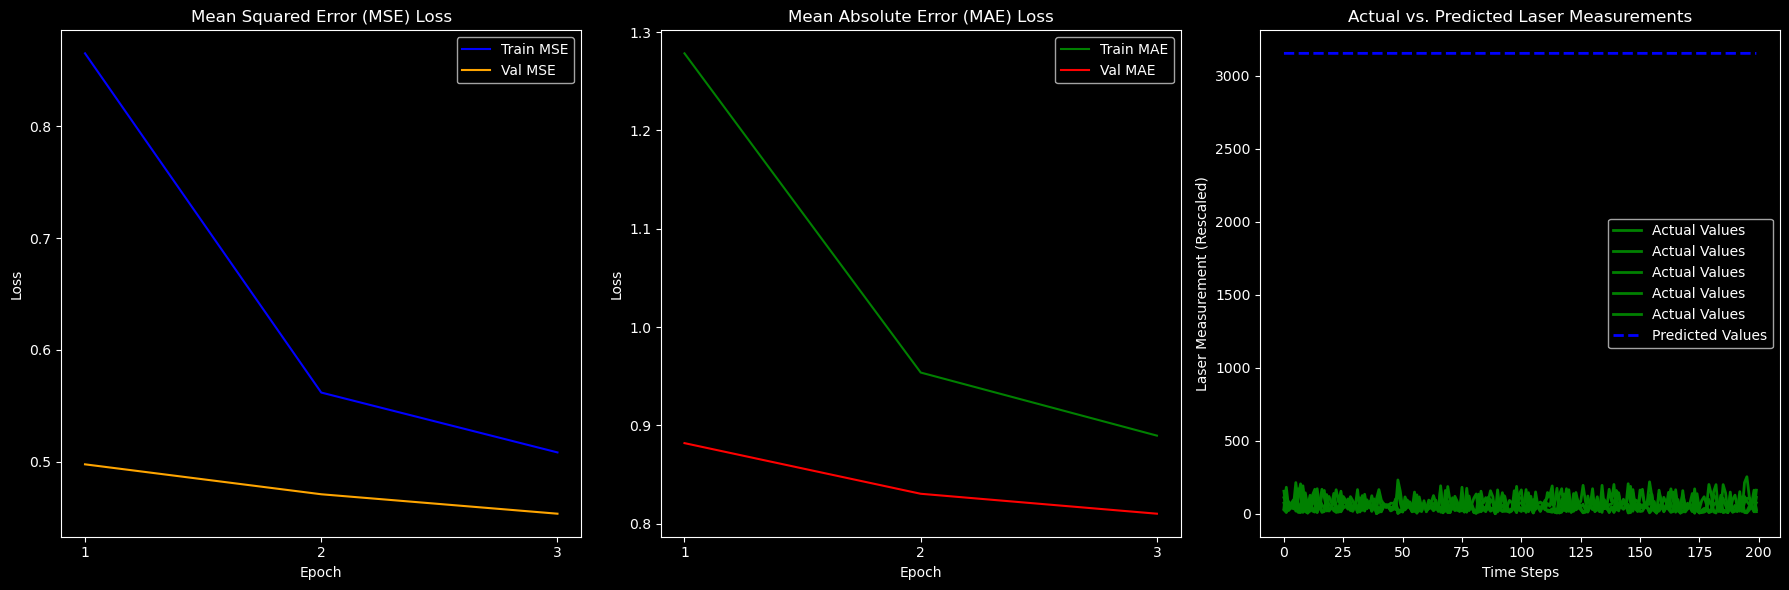

Metrics plot saved to training_summary.png


In [16]:
# Perform recursive forecasting to generate predictions
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200, std=std, mean=mean)

# Rescale predictions and actual values for comparison
predictions_rescaled = np.array(predictions) * std + mean
actual_values = y_val[:len(predictions_rescaled)] * std + mean  # Rescale to the original range

# Plot training and validation metrics
plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions_rescaled, actual_values)

### Save the trained model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "time_series_transformer.pth")
print("Model saved as time_series_transformer.pth")

### Load the trained model

In [ ]:
# Load
model = TimeSeriesTransformer(model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)
model.load_state_dict(torch.load("time_series_transformer.pth"))
model.to(device)

### Predict the next 200 data points recursively

In [ ]:
# Recursive forecasting for 200 steps
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200, std=std, mean=mean)

# Debugging: Print raw predictions
print(f"Raw predictions (first 10): {predictions[:10]}")

# Correctly rescale predictions back to the original range
predictions_rescaled = np.array(predictions) * std + mean

# Correctly rescale actual values for comparison
actual_values = y_val[:len(predictions_rescaled)] * std + mean  # Rescale to the original range

# Debugging: Print the ranges of predictions and actual values
print(f"max prediction: {np.max(predictions_rescaled)}, min prediction: {np.min(predictions_rescaled)}")
print(f"max actual: {np.max(actual_values)}, min actual: {np.min(actual_values)}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Laser Measurement (Rescaled)", fontsize=14)
plt.title("Actual vs. Predicted Laser Measurements", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("actual_vs_predicted_plot.png", dpi=300)  # Save the plot as a high-resolution image
plt.show()